# 1. 数据准备

图像数据准备方法：

1、用tf.keras中的ImageDataGenerator工具构建图片数据生成器；

2、使用tf.data.Dataset搭配tf.image中的一些图片处理方法构建数据管道（TensorFlow的原生方法）。

本文使用第2中方法准备图像数据

图像说明：

cifar2数据集为cifar10数据集的子集，只包括前两种类别airplane和automobile。

训练集有airplane和automobile图片各5000张，测试集有airplane和automobile图片各1000张。

cifar2任务的目标是训练一个模型来对飞机airplane和机动车automobile两种图片进行分类

In [37]:
import os
import datetime
import tensorflow as tf
from tensorflow.keras import models, layers, datasets
from tensorboard import notebook
import pandas as pd
import matplotlib.pyplot as plt

BATCH_SIZE = 100

In [38]:
def load_image(image_path, size=(32, 32)):
    # 正则匹配image_path与“.*automobile.*”
    if tf.strings.regex_full_match(image_path, '.*automobile.*'):
        label = tf.constant(1, tf.int8)
    else:
        label = tf.constant(0, tf.int8)
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, size) / 255
    return img, label

In [39]:
# 使用并行化预处理num_parallel_calls 和预存数据prefetch来提升性能
ds_train = tf.data.Dataset.list_files('../data/cifar2/train/*/*.jpg') \
            .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
            .shuffle(buffer_size=1000).batch(BATCH_SIZE) \
            .prefetch(tf.data.experimental.AUTOTUNE)
ds_test = tf.data.Dataset.list_files('../data/cifar2/test/*/*.jpg') \
            .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
            .batch(BATCH_SIZE) \
            .prefetch(tf.data.experimental.AUTOTUNE)

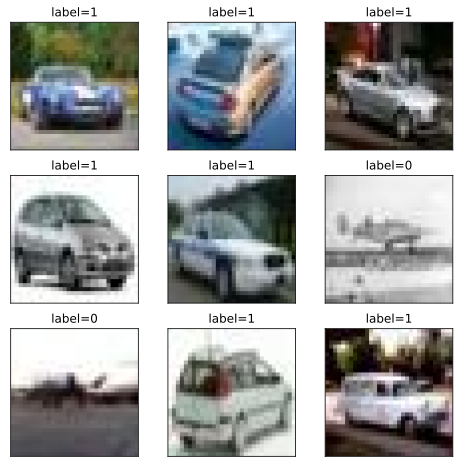

In [43]:
# 查看部分数据
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize=(8, 8))
for i, (img, label) in enumerate(ds_train.unbatch().take(9)):
    ax = plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title('label=%d' %label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [54]:
for x, y in ds_train.take(1):
    print(x.shape, y.shape)

(100, 32, 32, 3) (100,)


# 2. 创建模型

In [55]:
# 使用函数API创建模型
tf.keras.backend.clear_session()   # 清空会话

inputs = layers.Input(shape=(32,32,3))
x = layers.Conv2D(32, activation='relu', kernel_size=(3,3))(inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, activation='relu', kernel_size=(5,5))(x)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0     

# 3. 模型训练

In [57]:
stamp = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
logdir = os.path.join('data', 'autograph', stamp)

tensorboard_callbacks = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             loss=tf.keras.losses.binary_crossentropy,
             metrics=['accuracy'])

history = model.fit(ds_train, epochs=10, validation_data=ds_test, 
                    callbacks=[tensorboard_callbacks], workers=4)

Epoch 1/10
100/100 [==============================] - 28s 279ms/step - loss: 0.4775 - accuracy: 0.7661 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
100/100 [==============================] - 15s 151ms/step - loss: 0.3217 - accuracy: 0.8590 - val_loss: 0.2538 - val_accuracy: 0.8975
Epoch 3/10
100/100 [==============================] - 14s 141ms/step - loss: 0.2686 - accuracy: 0.8881 - val_loss: 0.2180 - val_accuracy: 0.9115
Epoch 4/10
100/100 [==============================] - 16s 157ms/step - loss: 0.2212 - accuracy: 0.9112 - val_loss: 0.2039 - val_accuracy: 0.9165
Epoch 5/10
100/100 [==============================] - 16s 161ms/step - loss: 0.1969 - accuracy: 0.9219 - val_loss: 0.1771 - val_accuracy: 0.9300
Epoch 6/10
100/100 [==============================] - 16s 163ms/step - loss: 0.1735 - accuracy: 0.9312 - val_loss: 0.1615 - val_accuracy: 0.9380
Epoch 7/10
100/100 [==============================] - 16s 164ms/step - loss: 0.1575 - accuracy: 0.9402 - val_loss: 0.1604 

# 4. 模型评估

In [59]:
%load_ext tensorboard

notebook.list()

No known TensorBoard instances running.


In [70]:
notebook.start('--logdir ../data/keras_model')

Reusing TensorBoard on port 6006 (pid 285796), started 0:00:55 ago. (Use '!kill 285796' to kill it.)

In [74]:
dfhistory = pd.DataFrame(history.history)
dfhistory.index = range(1, len(dfhistory) + 1)
dfhistory.index.name = 'epochs'
dfhistory

,loss,accuracy,val_loss,val_accuracy
epochs,,,,
1,0.477536,0.7661,0.351572,0.8580
2,0.321897,0.8590,0.253770,0.8975
3,0.269017,0.8881,0.217962,0.9115
4,0.220559,0.9112,0.203869,0.9165
5,0.196092,0.9219,0.177074,0.9300
6,0.173438,0.9312,0.161466,0.9380
7,0.157674,0.9402,0.160449,0.9375
8,0.141928,0.9474,0.148809,0.9445
9,0.132869,0.9495,0.142775,0.9455


In [75]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_metric(history, metric):
    train_metric = history.history[metric]
    val_metric = history.history['val_' + metric]
    epochs = range(1, len(train_metric) + 1)
    plt.plot(epochs, train_metric, 'bo--')
    plt.plot(epochs, val_metric, 'ro--')
    plt.title('Training and Validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend(['train_' + metric, 'val_' + metric])
    plt.show()

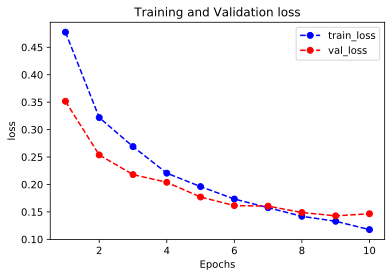

In [76]:
plot_metric(history, 'loss')

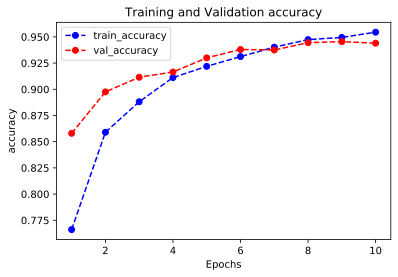

In [77]:
plot_metric(history, 'accuracy')

In [78]:
# 使用evaluate进行评估
val_loss, val_acc = model.evaluate(ds_test)
print(val_loss, val_acc)

20/20 [==============================] - 2s 112ms/step - loss: 0.1466 - accuracy: 0.9440
0.1465864136815071 0.944


# 5. 模型预测

In [79]:
model.predict(ds_test)

array([[9.8390019e-01],
       [9.9974644e-01],
       [1.2383166e-01],
       ...,
       [9.9191695e-01],
       [9.1307866e-04],
       [9.9999619e-01]], dtype=float32)

In [80]:
# 使用model.predict_on_batch(x_test)对一个批量进行预测
for x, y in ds_test.take(1):
    print(model.predict_on_batch(x[0:20]))

tf.Tensor(
[[9.27382529e-01]
 [2.55851746e-02]
 [3.13368440e-03]
 [7.97775388e-01]
 [9.28916514e-01]
 [4.54851985e-03]
 [9.99631286e-01]
 [9.86913443e-01]
 [7.86300302e-01]
 [9.99978125e-01]
 [1.22676075e-01]
 [1.23432249e-01]
 [9.17894304e-01]
 [1.93700194e-03]
 [9.99842823e-01]
 [2.30105549e-01]
 [9.99999285e-01]
 [3.33366515e-05]
 [1.92638990e-02]
 [2.00636640e-01]], shape=(20, 1), dtype=float32)


# 6. 模型保存

In [81]:
# 创建保存目录
os.mkdir('./data/tf_model_savedmodel')

model.save('./data/tf_model_savedmodel', save_format='tf')

model_load = tf.keras.models.load_model('./data/tf_model_savedmodel')
model_load.evaluate(ds_test)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./data/tf_model_savedmodel\assets
20/20 [==============================] - 2s 116ms/step - loss: 0.1466 - accuracy: 0.9440


[0.1465861976146698, 0.944]